# ****[Analytics] abdi, opencv를 활용한 적상추 생육 정량 지표 발굴****

## 기본설정

In [ ]:
# 단계 1: 폰트 설치
import matplotlib.font_manager as fm

!apt-get -qq -y install fonts-nanum > /dev/null
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
fm._rebuild()

In [ ]:
# 단계 2: 런타임 재시작
import os
os.kill(os.getpid(), 9)

여기까지 진행하고 다시 아래 셀부터 다시 실행

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# 단계 3: 라이브러리 import 한글 폰트 설정
#cv2 관련 import 와 cv2_imshow 
import cv2 as cv
from google.colab.patches import cv2_imshow

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm

import seaborn as sns
sns.set(font="Malgun Gothic",rc={"axes.unicode_minus":False},style="darkgrid")

import numpy as np
import pandas as pd
import math

import os
import glob

# 마이너스 표시
mpl.rcParams['axes.unicode_minus'] = False
	
# 한글 폰트 설정
path = '/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf'
font_name = fm.FontProperties(fname=path, size=18).get_name()
plt.rc('font', family=font_name)
fm._rebuild()

## 1. 개요 및 서론

In [ ]:
img = cv.imread("/content/drive/MyDrive/그림1_2.png") #경로
cv2_imshow(img)

본 분석은 파이썬의 opencv 라이브러리를 통해 **적상추 이미지에서 생육정도를 추정 가능한 정량 지표를 발굴**을 목적으로 한다.

 cv2 라이브러리를 활용해 이미지에서 적상추의 전체 면적 도출과 더불어 농촌진흥청의 출하기준에 맞추어 적색과 청색의 비율과 출하 가능 넓이 기준을 도출하고자 한다.

### 1.1 목표

1. 이미지에서 적상추의 전체면적도출
2. 이미지에서 적상추의 적/청색 비율 도출
3. 이미지에서 출하넓이기준  도출


### 1.2 데이터

1. 적상추 이미지 데이터셋
2. 청경채 이미지 CASE45_17.png

## 2. 분석 과정

### 2.1 전체 면적 도출

1. **이미지 마스킹 색상 범위 지정**

먼저 이미지 중 적색과 청색이 고루 분포한 이미지를 선택해 추출 색 범위를 맞춰 주도록 한다.

opencv 라이브러리는 기본적으로 BGR 채널로 이미지를 받아오기 때문에 비교적 노이즈가 적게 추출되는 HSV 형식으로 전환하여 진행한다.

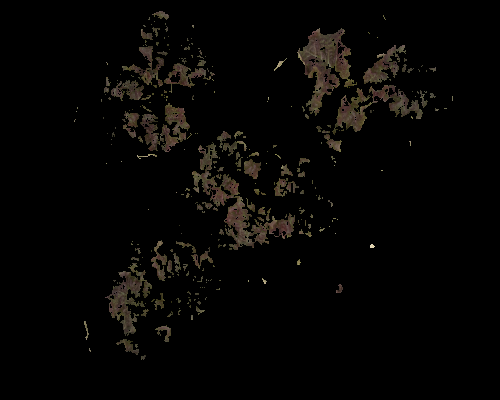

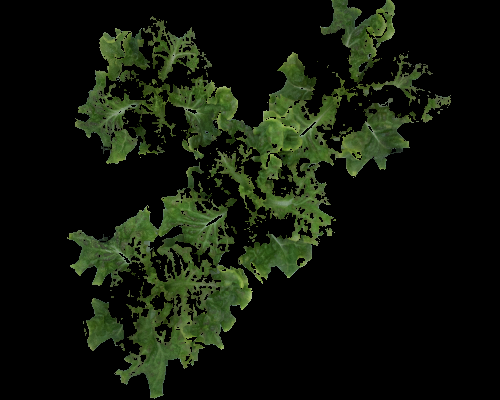

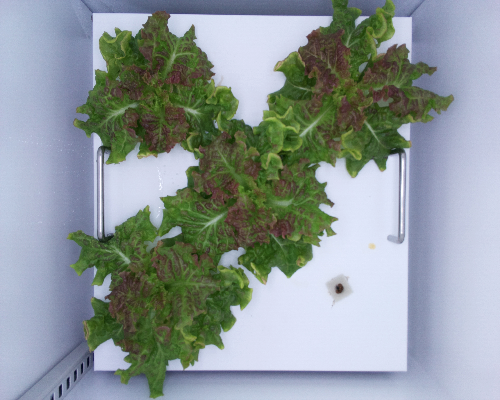

In [ ]:
# 적색과 청색을 모두 보이는 이미지 선택
resize = cv.resize(cv.imread('/content/drive/MyDrive/red_lettuce/CASE1/image_20210416/1621446371605.png'),(500 , 400)) # 경로
resize=cv.cvtColor(resize,cv.COLOR_BGR2HSV)
original=cv.cvtColor(resize,cv.COLOR_HSV2BGR)

#hsv로 색 추출
green_Lower=np.array([38,40,40])
green_Upper=np.array([80,255,255])

red_Lower=np.array([0,40,40])
red_Upper=np.array([30,255,255])

# mask
img_mask_green=cv.inRange(resize,green_Lower,green_Upper)
result_green=cv.bitwise_and(original,original,mask=img_mask_green)

img_mask_red=cv.inRange(resize,red_Lower,red_Upper)
result_red=cv.bitwise_and(original,original,mask=img_mask_red)

#show
cv2_imshow(result_red)
cv2_imshow(result_green)
cv2_imshow(original)

각 색상부분이 잘 마스킹 된 것을 확인할 수 있다.

다음은 마스킹이미지를 통해 면적 추출을 위한 contour(등고선)를 검출한다.

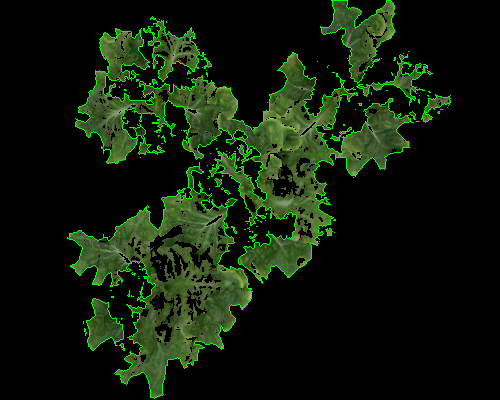

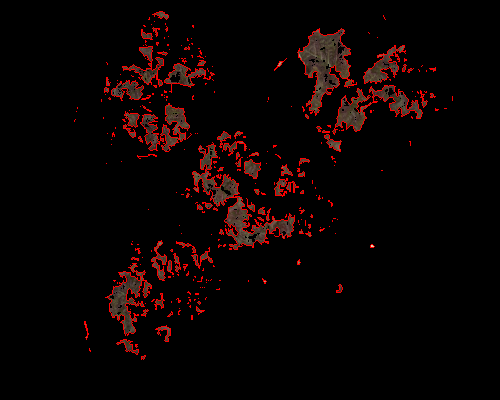

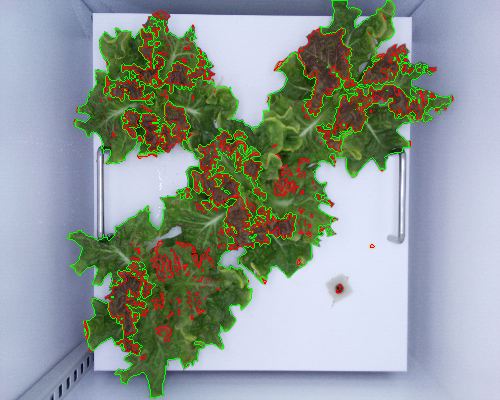

In [ ]:
# contour_green
contours_green, _ = cv.findContours(img_mask_green, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
cv.drawContours(original, contours_green, -1, (0, 255, 0), 1)
cv.drawContours(result_green, contours_green, -1, (0, 255, 0), 1)

# contour_red
contours_red, _ = cv.findContours(img_mask_red, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
cv.drawContours(original, contours_red, -1, (0, 0, 255), 1)
cv.drawContours(result_red, contours_red, -1, (0, 0, 255), 1)

cv2_imshow(result_green)
cv2_imshow(result_red)
cv2_imshow(original)

색상별로 contour가 잘 검출된것을 확인할 수 있다.

2. **전체 이미지 불러오기 및 면적 도출**

이제 전체이미지를 불러와 위에서 지정한 색상 범위로 면적도출을 진행한다.

In [ ]:
# 적상추 이미지에서 청색면적, 전체면적, 청색비율 뽑기
dfs_area=[]

for i in range(10):
    area_green_list=[]
    area_red_list=[]
    area_total_list=[]

    default_path = "/content/drive/MyDrive/red_lettuce/CASE"+str(i+1)+"/" #경로

    folder_list = os.listdir(default_path)
    #print(folder_list)
    
    folder=[]
    folder = [file for file in folder_list if file.startswith('image')]
    #print(folder)

    image_path=default_path+folder[0]+"/"

    image_list = sorted(os.listdir(image_path))
    #print(image_list)

    for index , path in enumerate(image_list):
        real_path = ""
        real_path = image_path + path
        #청색 범위
        green_Lower=np.array([35,40,40])
        green_Upper=np.array([80,255,255])
    
        #적색 범위
        red_Lower=np.array([0,40,40])
        red_Upper=np.array([30,255,255])

        #path 가 있으면
        img = cv.imread(real_path)

        #BGR to HSV
        img_hsv= cv.cvtColor(img , cv.COLOR_BGR2HSV)
        # mask
        img_mask_green=cv.inRange(img_hsv,green_Lower,green_Upper)
        img_mask_red=cv.inRange(img_hsv,red_Lower,red_Upper)
        # contour
        contours_green, _ = cv.findContours(img_mask_green, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        contours_red, _ = cv.findContours(img_mask_red, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

        #contour_area green
        area_green=0
        for k in range(0,(len(contours_green))):
            area_green+=cv.contourArea(contours_green[k])
        area_green_list.append(area_green)

        #contour_area red
        area_red=0
        for k in range(0,(len(contours_red))):
            area_red+=cv.contourArea(contours_red[k])
        area_red_list.append(area_red)

        #total_area 전체면적
        total_area=area_green+area_red
        area_total_list.append(total_area)
        
    df_area = pd.DataFrame({'청색면적':area_green_list, '적색면적':area_red_list, '전체면적':area_total_list })
    dfs_area.append(df_area)

3. **추출 면적 값 확인**

len(dfs_area)의 결과값이 10으로 10개의 CASE가 잘 들어왔다면 추출한 면적이  생육정도를 잘 대표하는지 시각화를 통해 확인한다.

In [ ]:
len(dfs_area)

In [ ]:
f, axes = plt.subplots(5, 2)
f.set_size_inches((50,45))

for i in range(len(dfs_area)):
    dfv=dfs_area[i]
    x=np.arange(len(dfv['전체면적']))
    plt.subplot(5,2,i+1)
    plt.plot(x,dfv['전체면적'], color='blue',linewidth=7.0)
    plt.title("전체 면적: CASE"+str(i+1),fontsize=35)

10개의 CASE 모두 적상추의 성장에 따른 면적을 잘 추출하는 것을 확인 할 수 있다.

특히 CASE01에서 가장 크게 성장한 정점 면적을 기준으로 시들며 다시 면적이 줄어드는 과정과 적상추가 대략 반정도만 찍힌 CASE03의 마지막 이미지의 면적도 바르게 추출한 것을 확인 할 수 있다.

또한 전체, 적색, 청색 면적의 성장 곡선은 다음과 같다.

In [ ]:
f, axes = plt.subplots(5, 2)
f.set_size_inches((50,45))

for i in range(len(dfs_area)):
    dfv=dfs_area[i]
    x=np.arange(len(dfv['전체면적']))
    plt.subplot(5,2,i+1)
    plt.plot(x,dfv['전체면적'], color='gray',linewidth=7.0)
    plt.plot(x,dfv['청색면적'], color='lightgreen',linewidth=7.0)
    plt.plot(x,dfv['적색면적'], color='red',alpha=0.5,linewidth=7.0)
    plt.title("면적 성장 비교: CASE"+str(i+1),fontsize=35)

적/청색의 면적 또한 잘 추출하는 것을 확인 할 수 있다.

특히 마지막에 적색의 면적이 증가하고 청색의 면적이 감소하는  CASE01의 면적도 잘 추출한 것을 확인 할 수 있다.

### 2.2 청/적색 비율 도출

이번엔 출하기준 중 하나인 적색과 청색의 면적 비율 지표를 산출한다.

출하기준은 적색:청색의 비율이 7:3 이므로 본 분석에서는 전체면적 대비 청색비율을 추출하여 진행하도록 한다.

In [ ]:
for i in range(len(dfs_area)):
    dfs_area[i]['청색비율']=dfs_area[i]['청색면적']/dfs_area[i]['전체면적'] 

fig = plt.figure()
fig.set_size_inches((50,45))

for i in range(len(dfs_area)):
    ax=fig.add_subplot(5,2, i+1)
    x=np.arange(len(dfs_area[i]['전체면적']))
    ax.plot(x,dfs_area[i]['전체면적'], color = 'gray', alpha = 0.3,linewidth=4.0)
    plt.title("전체 면적과 청색비율: CASE"+str(i+1),fontsize=35)
    # ax2는 y2에 대한 그래프, twinx로 x축을 공유
    ax2 = ax.twinx()
    ax2.plot(x, dfs_area[i]['청색비율'], color = 'lightgreen',linewidth=7.0)
    ax2.axhline(0.3, 0, len(dfs_area[i]['전체면적']), color='green', linestyle='--', linewidth=3) # 기준 0.3 표시

청색 비율 지표 그래프를 통해 적/청색의 출하기준을 확인 할 수 있다.

그래프에서 출하 기준에 가장 가까운 값을 갖는 CASE는 CASE01이다.

하지만 면적이 충분히 크지 않은 경우에도 청색비율이 0.3 보다 낮게 확인되는 경우가 있기 때문에 **생육수준이 높은 면적에 대한 지표 기준 정의도 필요해 보인다.**

### 2.3 출하 적정 면적 도출

1. **청경채 이상이미지에서 면적 근사값 추출**

위의 출하 면적 기준 중 **성인손바닥넓이를 추출**하기 위해 적상추 이미지와 가장 비슷한 환경인 청경채 이미지 중 사람손이 나온 이상이미지를 활용하여 기준을 추출 해보겠습니다.

 먼저 적상추와 같은 방식으로 사람 손 영역을 마스킹 해줍니다.

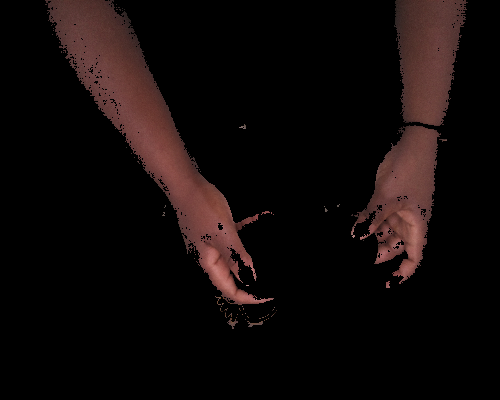

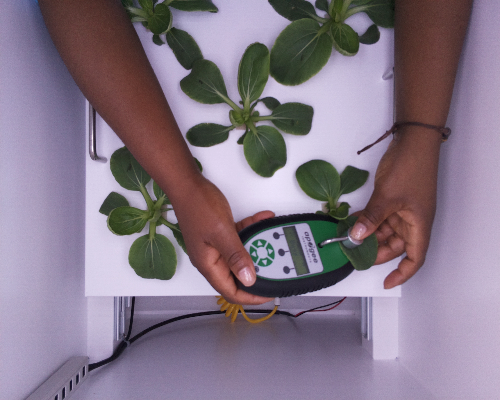

In [ ]:
# 청경채 이미지 중 손이 찍힌 이상이미지 불러오기
resize = cv.resize(cv.imread('/content/drive/MyDrive/open/train/CASE45/image/CASE45_17.png'),(500 , 400)) # [Algorithm]청경채 이미지 경로
resize=cv.cvtColor(resize,cv.COLOR_BGR2HSV)

original=cv.cvtColor(resize,cv.COLOR_HSV2BGR)
original1=cv.cvtColor(resize,cv.COLOR_HSV2BGR)
original2=cv.cvtColor(resize,cv.COLOR_HSV2BGR)


#hsv로 색 추출
hand_Lower=np.array([0,40,40])
hand_Upper=np.array([12,255,255])

# mask
img_mask_hand=cv.inRange(resize,hand_Lower,hand_Upper)
result_hand=cv.bitwise_and(original,original,mask=img_mask_hand)

#show
cv2_imshow(result_hand)
cv2_imshow(original)

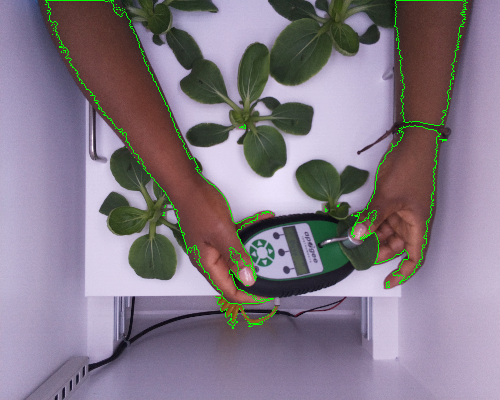

In [ ]:
# contour_hand
contours_hand, hierarchy = cv.findContours(img_mask_hand, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
cv.drawContours(original, contours_hand, -1, (0, 255, 0), 1)
cv.drawContours(result_hand, contours_hand, -1, (0, 255, 0), 1)

cv2_imshow(original)

영역 마스킹과 contour가 잘 추출된 것을 확인 할 수 있습니다. 

다음은 손만 따로 contour 처리된 우측 손 추출을 타겟으로 진행 하겠습니다.

In [ ]:
idx=[]
area=[]
for i in range(len(contours_hand)):
    a=cv.contourArea(contours_hand[i])
    area.append(a)
    idx.append(i)
    
df_area=pd.DataFrame({'idx1':idx,'area':area})
df_area = df_area.sort_values(by=["area"],ascending=False)
df_area.head(3)

,idx1,area
83,83,17511.5
57,57,7158.5
82,82,6671.0


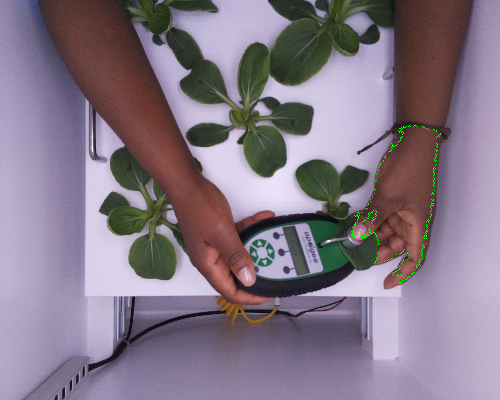

In [ ]:
contour=contours_hand[57]

cv.drawContours(original1, contour,-1, (0, 255, 0), 1)

cv2_imshow(original1)


잘 선택된것을 확인할 수 있습니다. 이제 손바닥을 근사하기 위해 중심점 기준 원을 그려주겠습니다

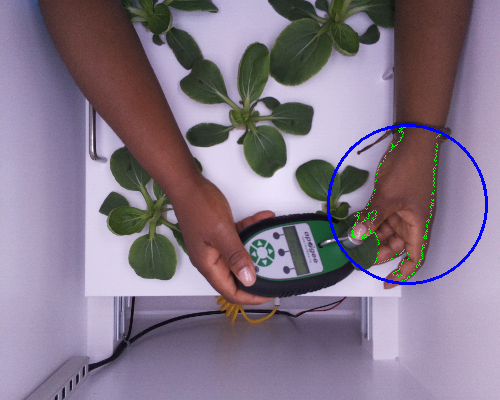

In [ ]:
(x,y), radius = cv.minEnclosingCircle(contour)

cv.circle(original1, (int(x), int(y)), int(radius), (255,0,0), 2)


cv2_imshow( original1)


손바닥면적을 근사할 것으로 추정되는 위 원의 넓이를 기준으로 출하기준을 구해줍니다.

In [ ]:
radius=int(radius)
hand_area=radius**2*3.14

print(f"손바닥 근사 면적(원의 넓이):{hand_area}")

area_guide=hand_area*5 # 한 이미지에 다섯포기의 상추가 자란다고 가정

print(f"생육 상위 이미지 면적 기준: {area_guide}")

손바닥 근사 면적(원의 넓이):19596.74
생육 상위 이미지 면적 기준: 97983.70000000001


위 기준을 적상추 면적성장 그래프에 표시 해보도록 하겠습니다.

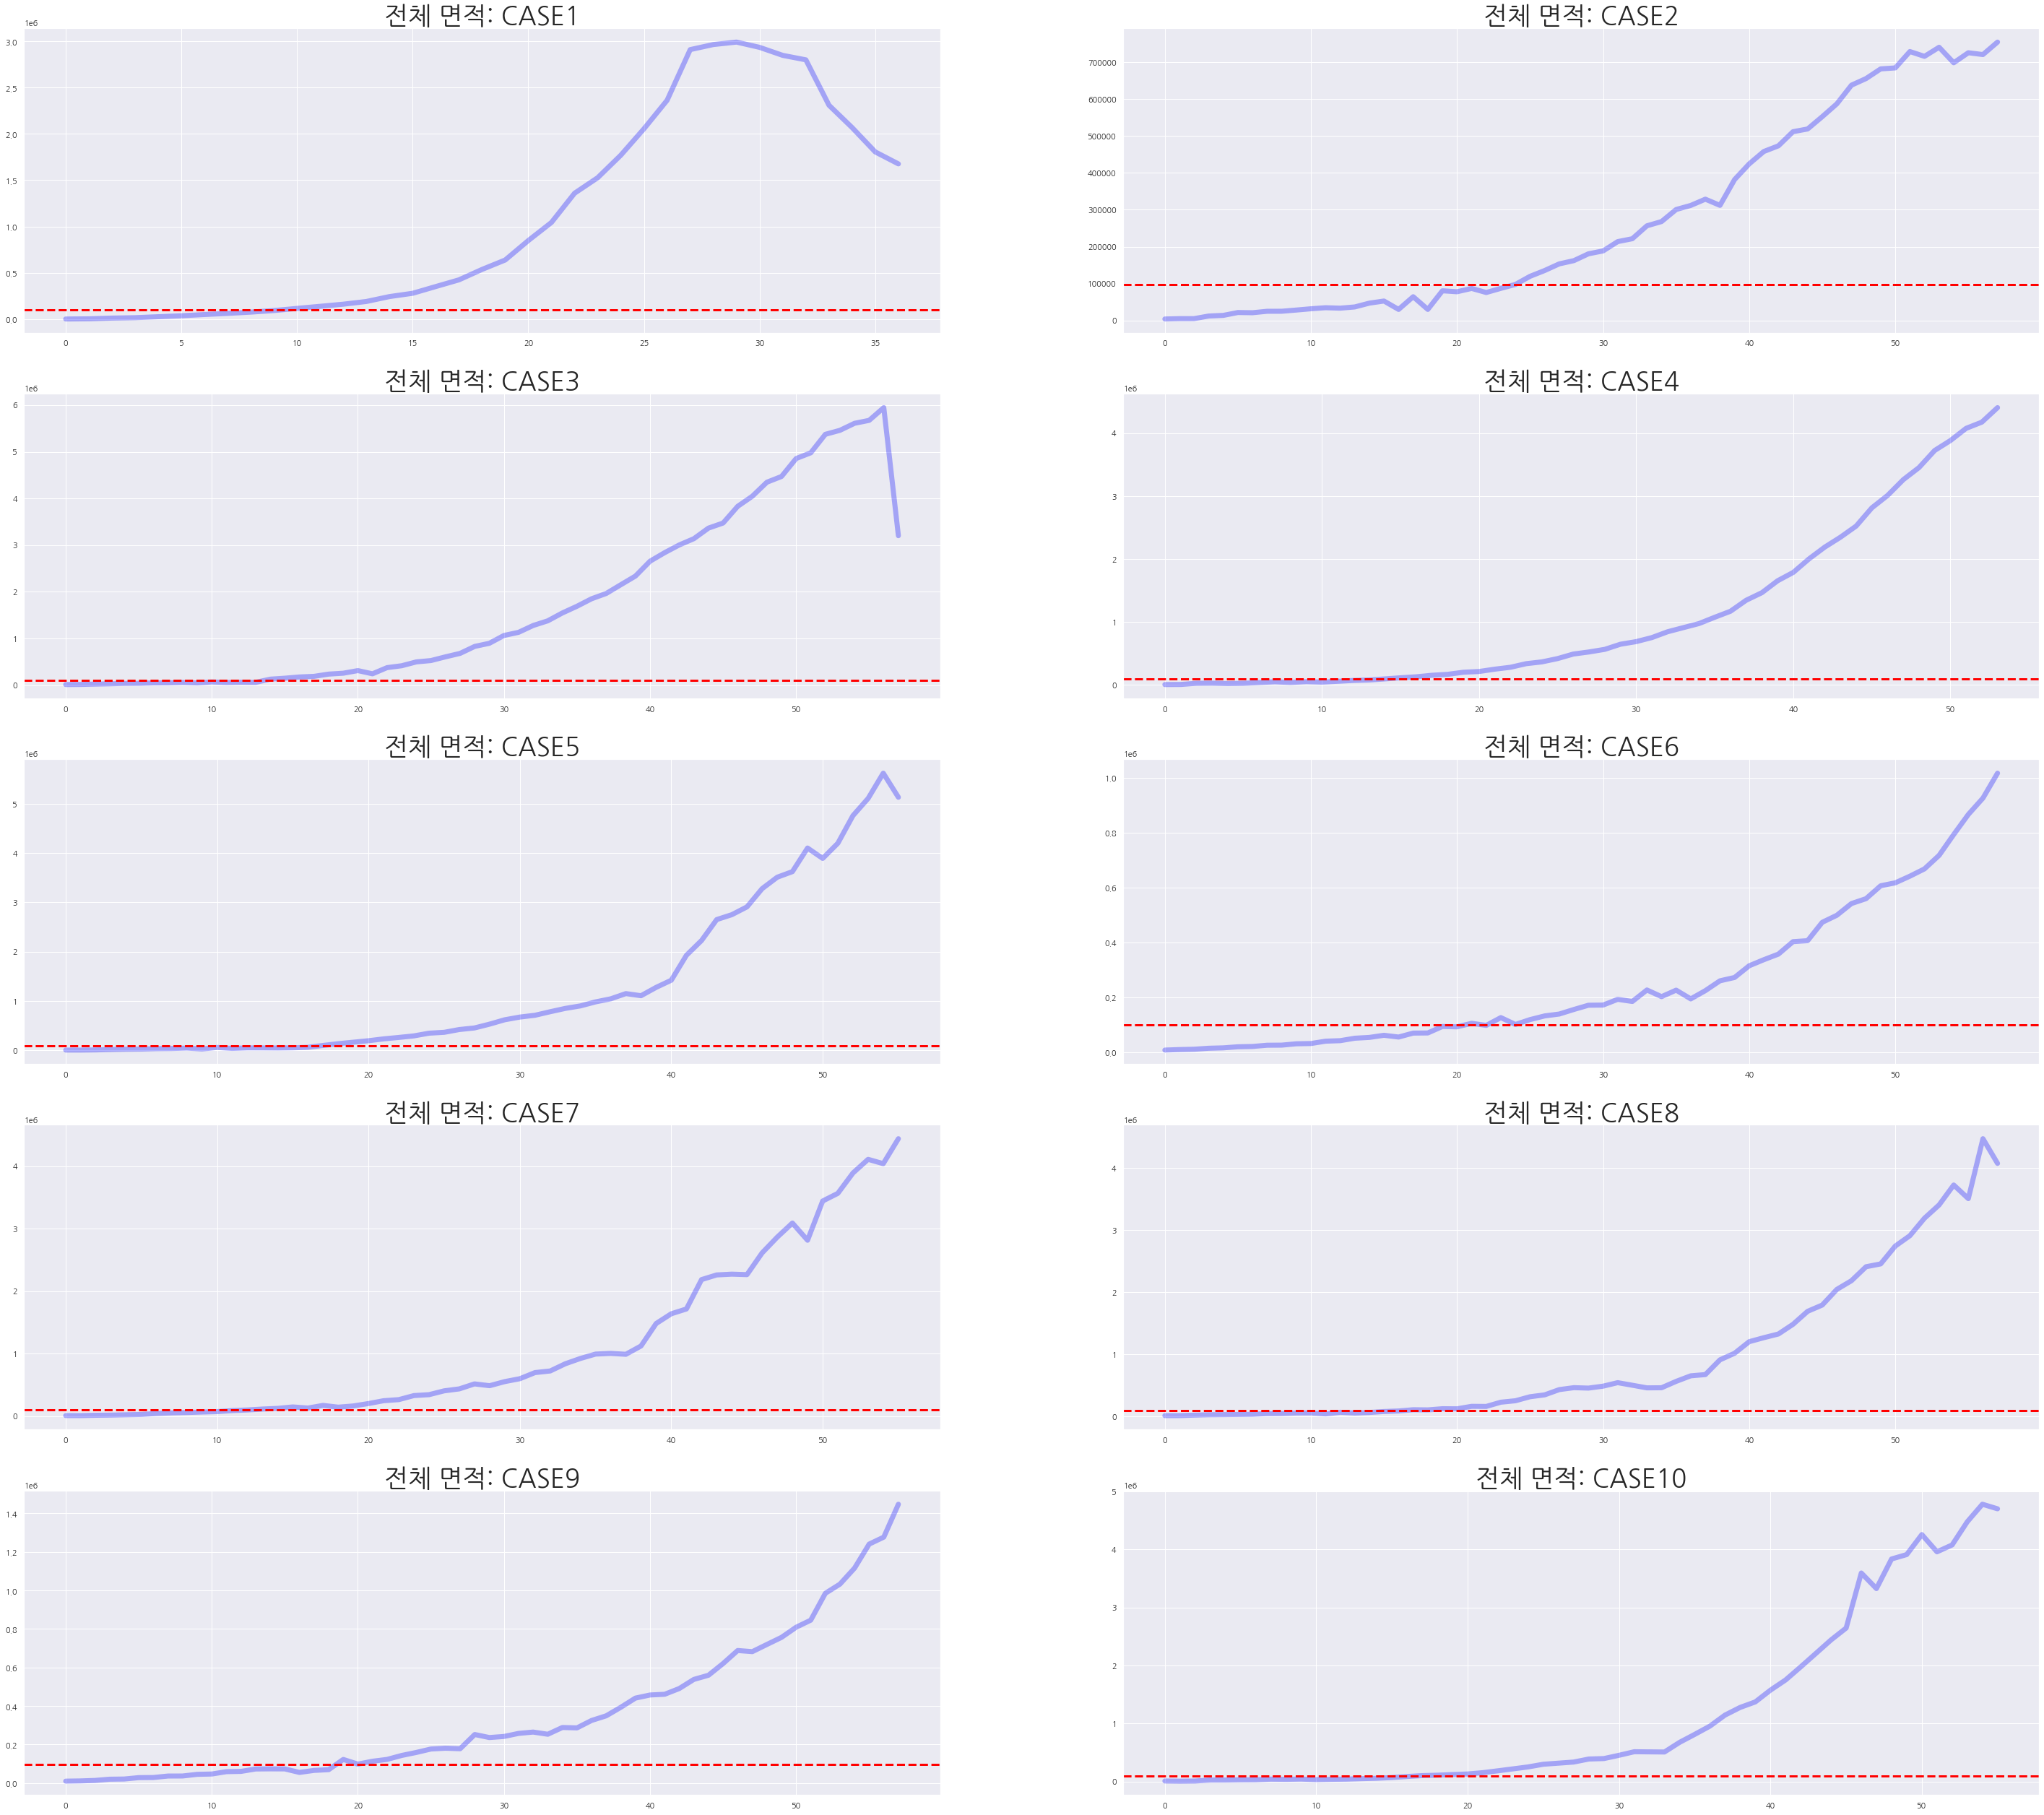

In [ ]:
f, axes = plt.subplots(5, 2)
f.set_size_inches((50,45))

for i in range(len(dfs_area)):
    dfv=dfs_area[i]
    x=np.arange(len(dfv['전체면적']))
    plt.subplot(5,2,i+1)
    plt.plot(x,dfv['전체면적'], color='blue',linewidth=7.0,alpha=0.3)
    plt.title("전체 면적: CASE"+str(i+1),fontsize=35)
    plt.axhline(area_guide, 0, len(dfs_area[i]['전체면적']), color='red', linestyle='--', linewidth=3)

굉장히 낮은 수치를 기준으로 잡고있는 것으로 나타납니다. 

이상이미지에서 구한 근사치인 것을 감안하더라도 기준수치로 사용하기엔 힘들어 보입니다.

다른방법으로 기준을 추출해 보겠습니다.

2. **전체면적분포를 이용한 기준 수립**

전체면적의 분포를 사용하여 기준을 수립해 보겠습니다.

먼저 리스트형태로 나눠져있는 데이터 프레임을 통합해줍니다.

In [ ]:
#case_idx 컬럼 설정 및 데이터프레임 통합
for i in range(len(dfs_area)):
    dfs_area[i]['case_idx']=i+1
    dfs_area[i]['img_idx']=range(len(dfs_area[i]))
df=pd.concat(dfs_area)

df=df.reset_index()
df

,index,청색면적,적색면적,전체면적,청색비율,case_idx,img_idx
0,0,0.0,120.0,120.0,0.000000,1,0
1,1,0.0,1943.5,1943.5,0.000000,1,1
2,2,0.0,10025.5,10025.5,0.000000,1,2
3,3,4525.5,9910.5,14436.0,0.313487,1,3
4,4,17132.0,7666.0,24798.0,0.690862,1,4
...,...,...,...,...,...,...,...
544,51,3148043.0,809842.5,3957885.5,0.795385,10,51
545,52,3303174.5,773643.5,4076818.0,0.810233,10,52
546,53,3633818.0,841741.0,4475559.0,0.811925,10,53
547,54,4218640.0,559745.5,4778385.5,0.882859,10,54


통합데이터프레임을 활용해 [전체면적] 컬럼의 분포를 확인합니다.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, '전체면적분포')

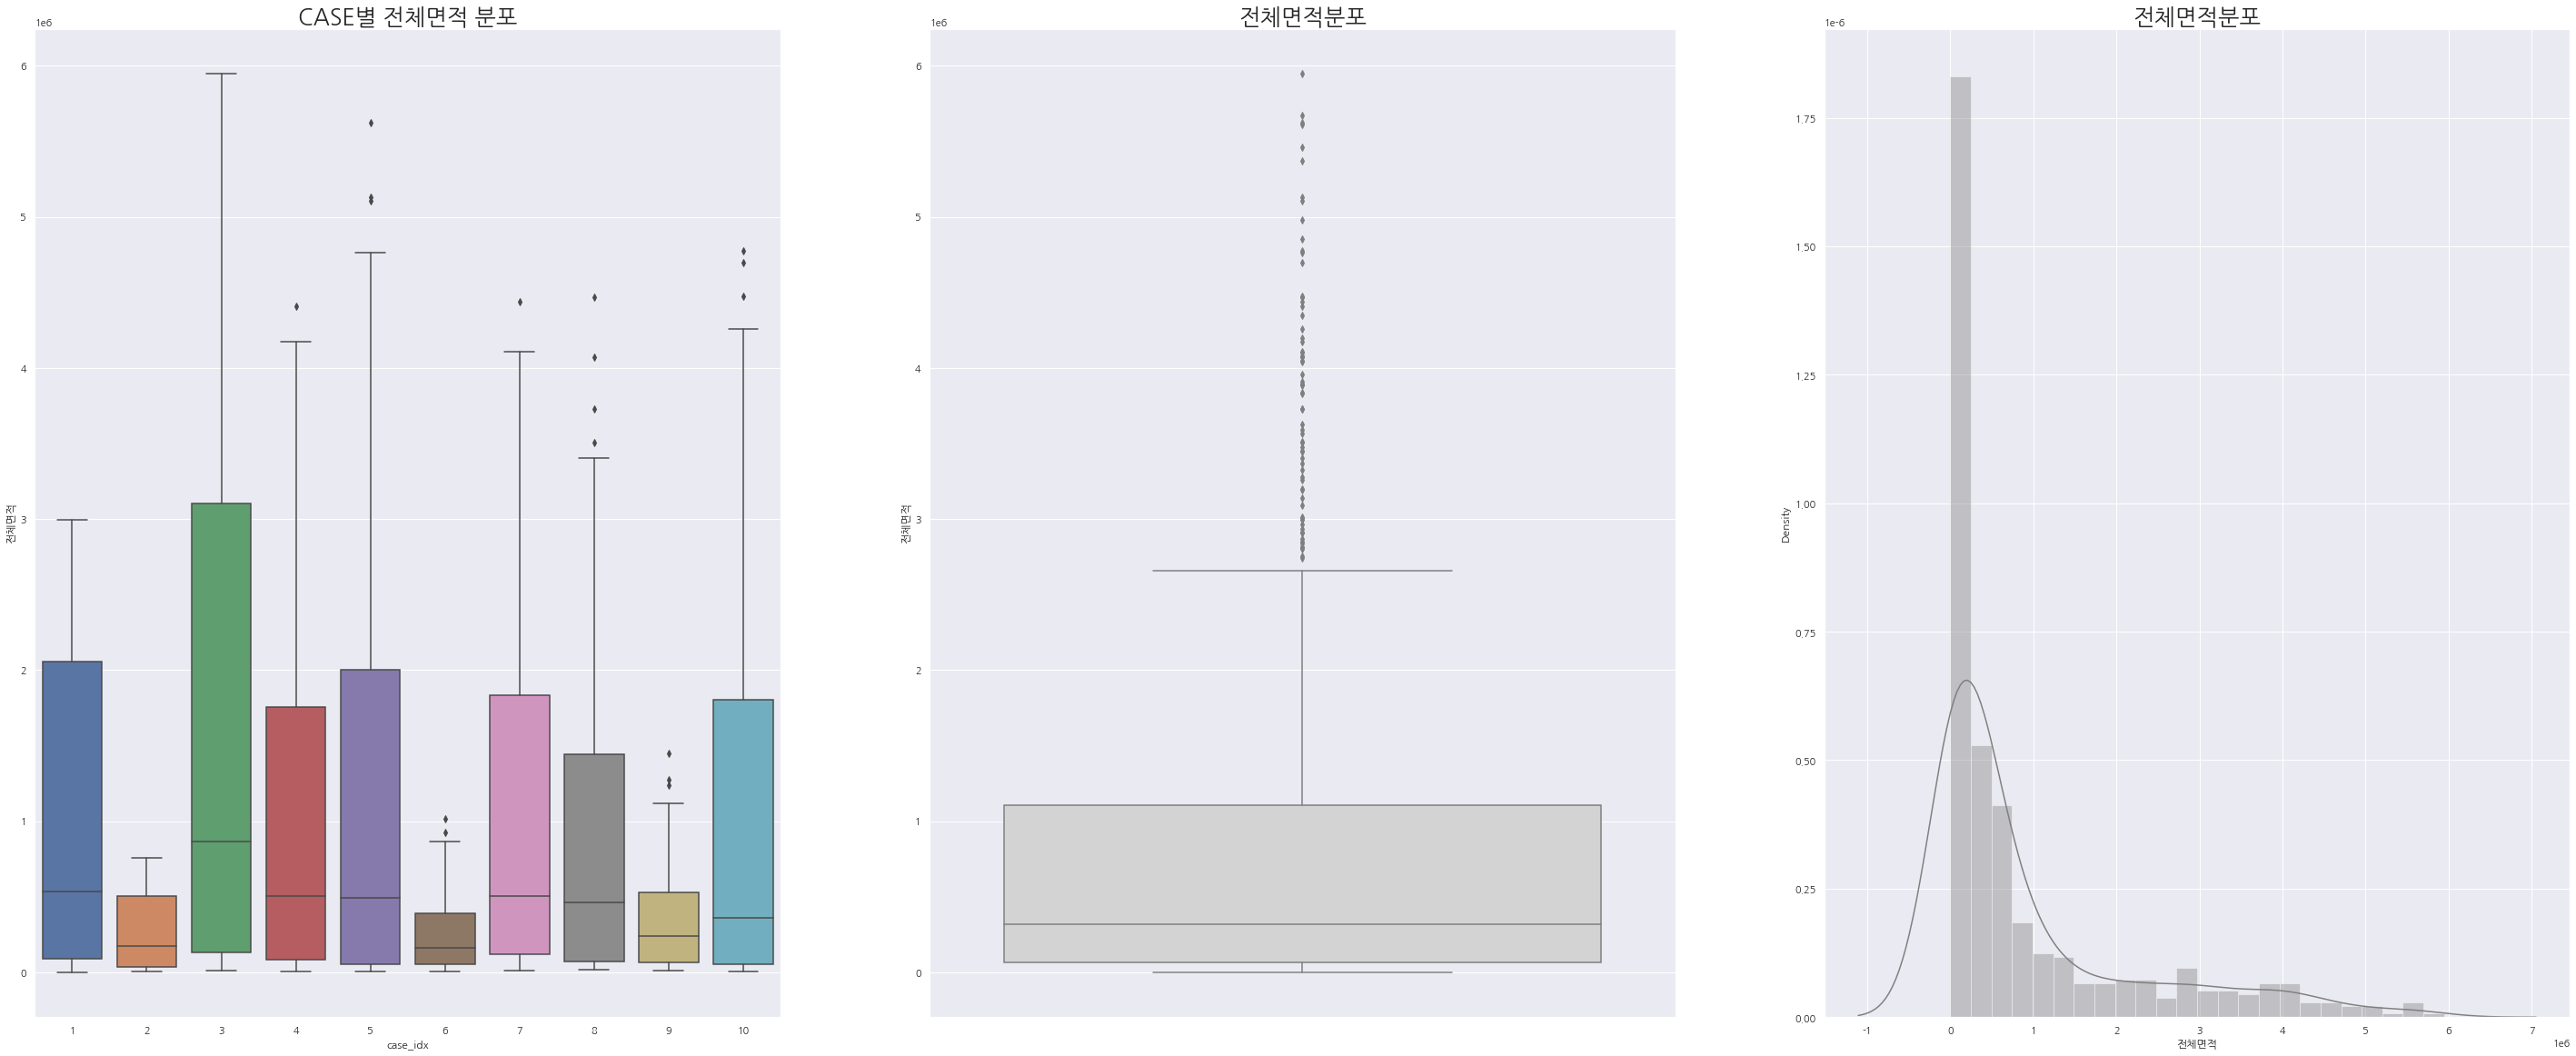

In [ ]:
# 분포
f, axes = plt.subplots(1, 3)
f.set_size_inches((50,20))

#전체면적 swarmplot
plt.subplot(1,3,1)
sns.boxplot(y = df["전체면적"], x = df['case_idx'])
plt.title("CASE별 전체면적 분포",fontsize=25)

#전체 면적 boxplot
plt.subplot(1,3,2)
sns.boxplot(y = df["전체면적"],color='lightgray')
plt.title("전체면적분포",fontsize=25)

#전체 면적 분포곡선
plt.subplot(1,3,3)
sns.distplot(df["전체면적"],color='gray')
plt.title("전체면적분포",fontsize=25)

전체면적 값의 분포에서 0에 가까운 면적수치가 많아 분포가 0에 치우친 것을 확인할 수 있습니다.

따라서 큰 전체면적수치가 이상치로 많이 분류되었습니다. 

상위 생육 수준의 전체면적 수치를 추출하기 위해 **전체면적 분포의 (3분위수+1.5*IQR)값을 기준**으로 분석을 진행했습니다.

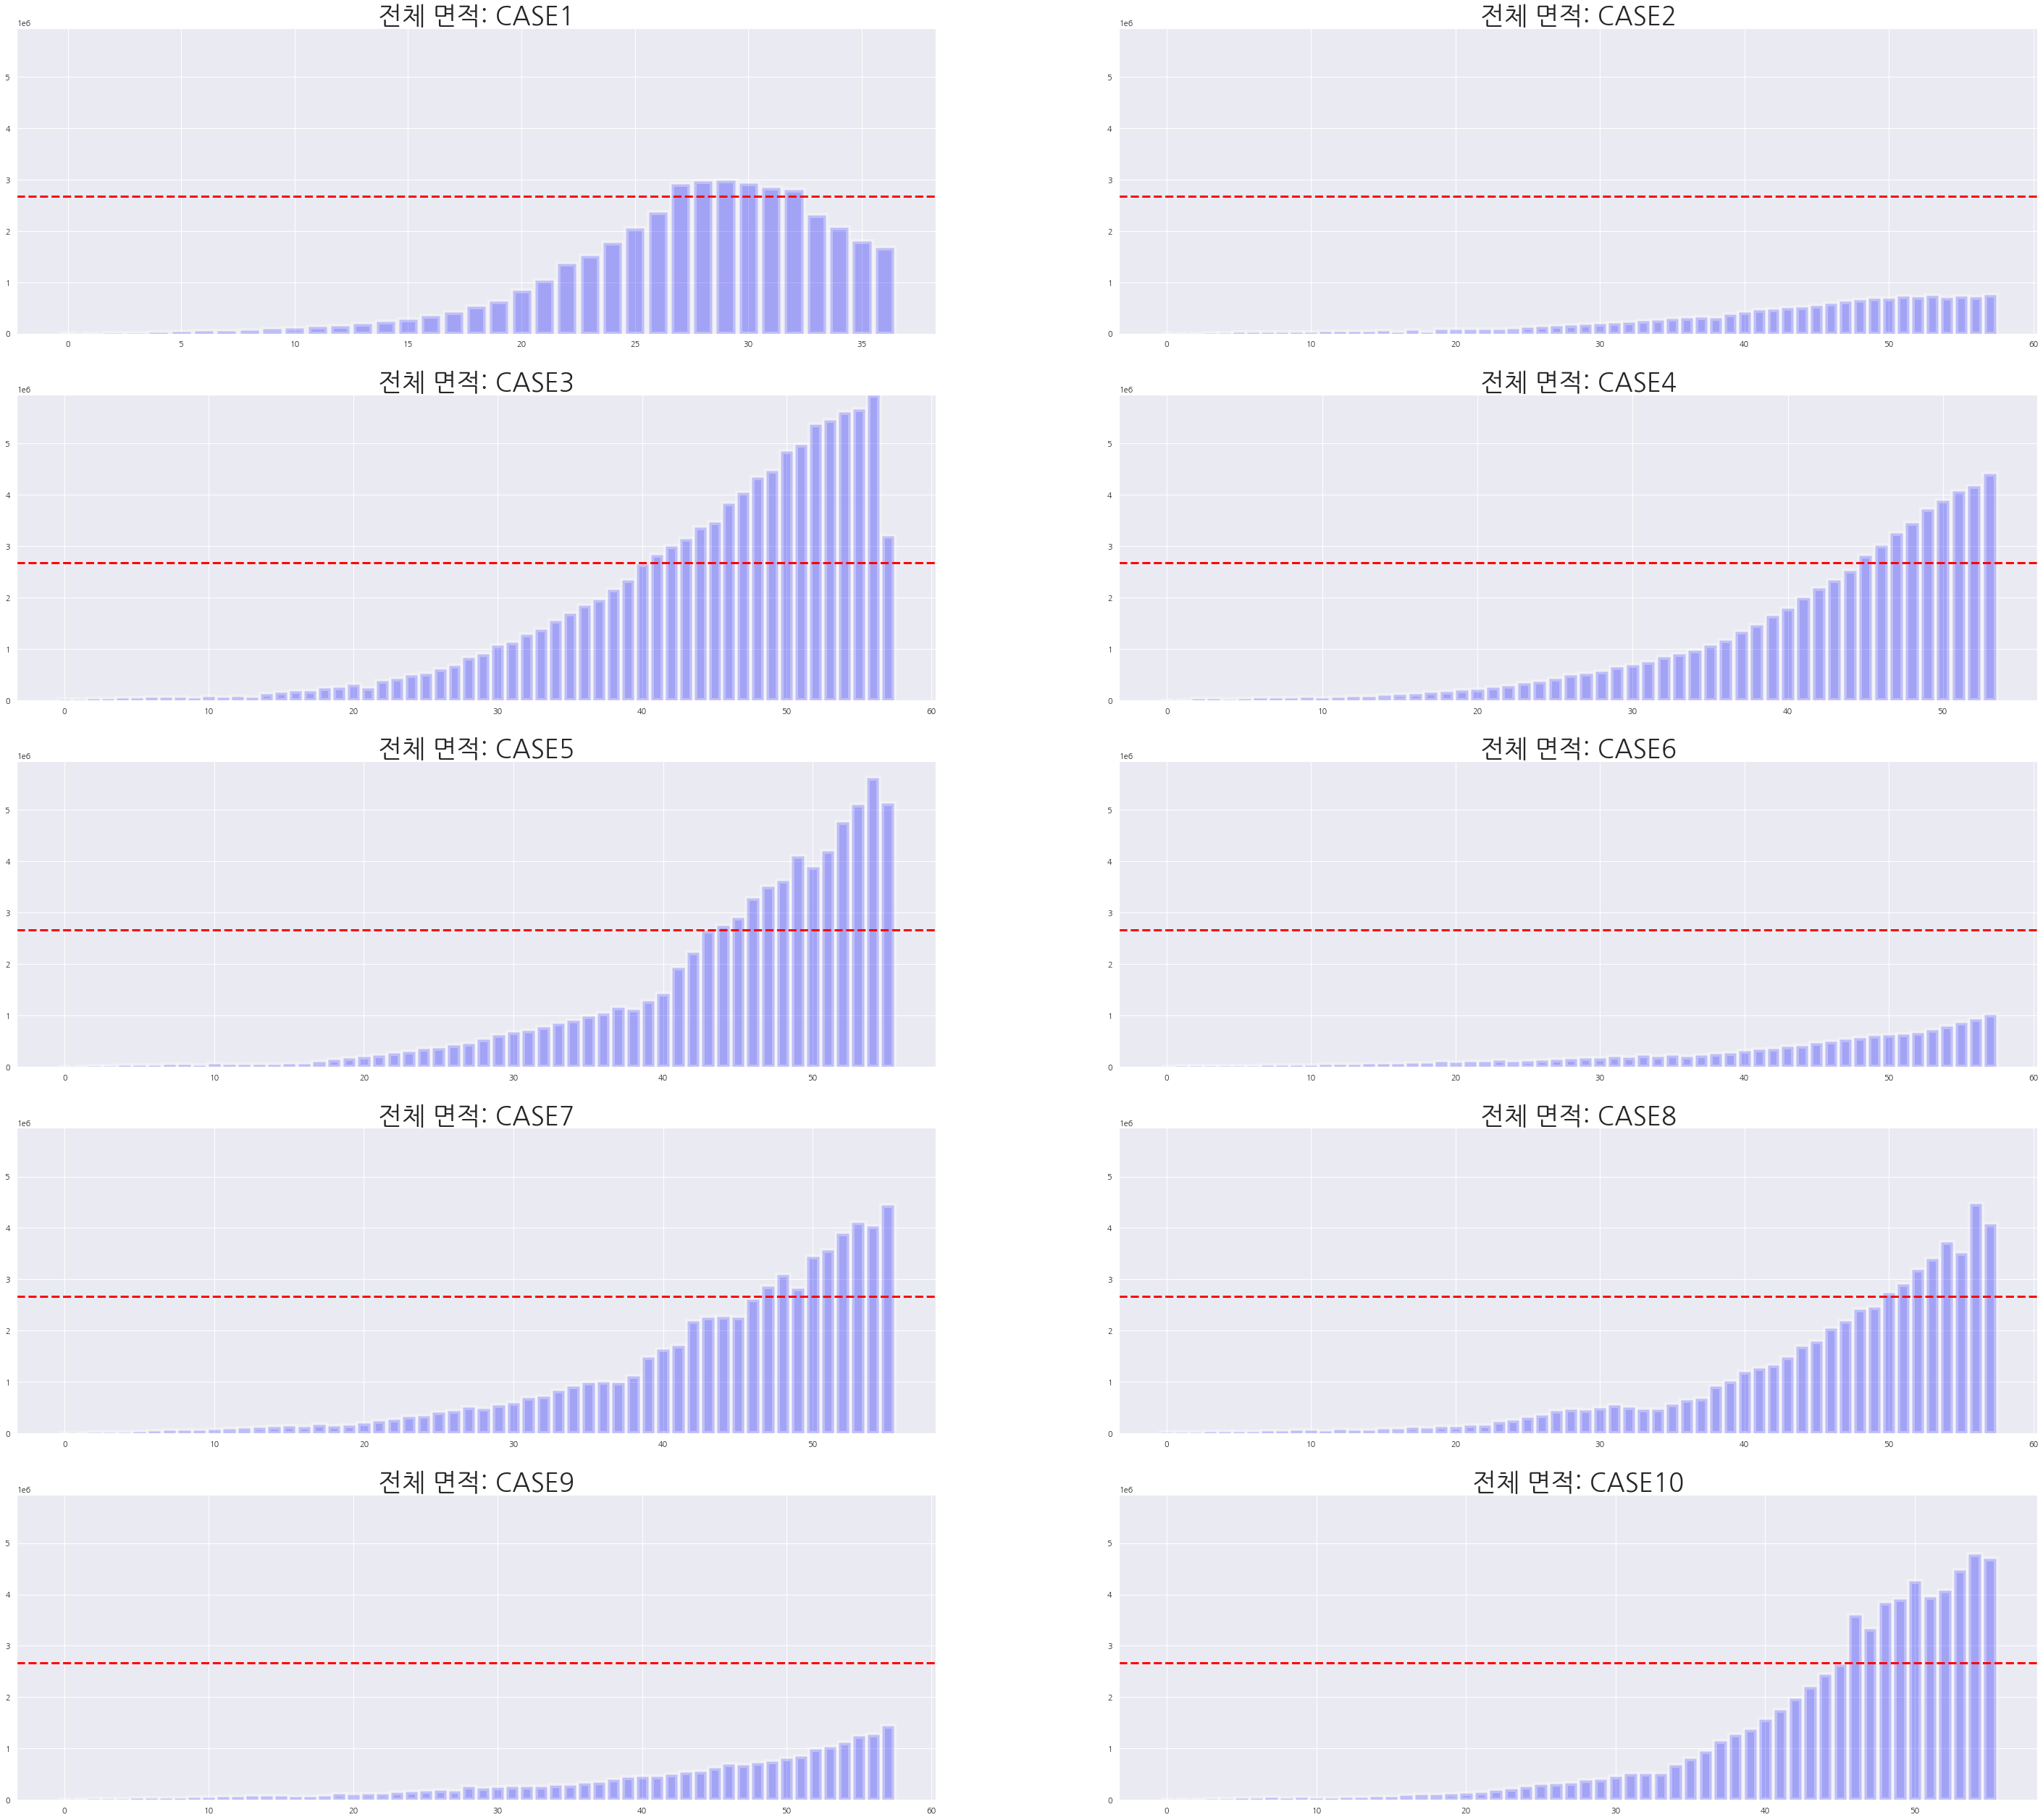

In [ ]:
IQR=df['전체면적'].quantile(0.75)-df['전체면적'].quantile(0.25)
max_except_outlier=(df["전체면적"].quantile(0.75)+1.5*IQR)


f, axes = plt.subplots(5, 2)
f.set_size_inches((50,45))


for i in range(len(dfs_area)):
    dfv=dfs_area[i]
    x=np.arange(len(dfv['전체면적']))
    plt.subplot(5,2,i+1)
    plt.bar(x,dfv['전체면적'], color='blue',linewidth=7.0,alpha=0.3)
    plt.title("전체 면적: CASE"+str(i+1),fontsize=35)
    plt.axhline(max_except_outlier, 0, len(dfs_area[i]['전체면적']), color='red', linestyle='--', linewidth=3)
    plt.ylim([0,max(df['전체면적'])]) 

기준 이상의 면적을 가진 이미지를 출력해보겠습니다.

In [ ]:
# 기준 이상의 면적 데이터프레임 추축
area_outlier=df[df['전체면적']>max_except_outlier]
area_outlier=area_outlier.sort_values(by=["전체면적"], ascending=True) 
area_outlier=area_outlier.head(15)

#이미지 경로 지정
outlier_img_list=[]
for i in area_outlier['case_idx'].unique():
    area_outlier_split=area_outlier[area_outlier['case_idx']==i]
    
    default_path = "/content/drive/MyDrive/red_lettuce/CASE"+str(i)+"/" # 경로

    folder_list = os.listdir(default_path)
    #print(folder_list)
    
    folder=[]
    folder = [file for file in folder_list if file.startswith('image')]
    # print(folder)

    image_path=default_path+folder[0]+"/"

    image_list = sorted(os.listdir(image_path))
   # print(image_list)
             
    idx_max=area_outlier_split['img_idx'].max()
    idx_min=area_outlier_split['img_idx'].min()
    image_list=image_list[int(idx_min):int(idx_max)+1]
    
    for list_idx in range(len(image_list)):
        image_list[list_idx]=image_path+image_list[list_idx]
        #print(image_list)
    outlier_img_list.extend(image_list)
    
#outlier_img_list

In [ ]:
#이미지 추출
f, axes = plt.subplots(math.ceil(len(outlier_img_list)/3), 3)
f.set_size_inches(70,80)

for path in outlier_img_list:
     
    plt.subplot(math.ceil(len(outlier_img_list)/3), 3,outlier_img_list.index(path)+1)
    
    img = cv.imread(path)
    img=cv.cvtColor(img,cv.COLOR_BGR2RGB)
    plt.imshow(img)
plt.show()

출력된 이미지와 그래프를 확인해 봤을때 절반만 나온 이상이미지와 육안으로 봤을때 아직 작은 크기의 적상추 이미지들이 함께 출력됐습니다.

따라서 **[전체면적] 기준을 Quantile 95% 로 더 높여보도록 하겠습니다**.

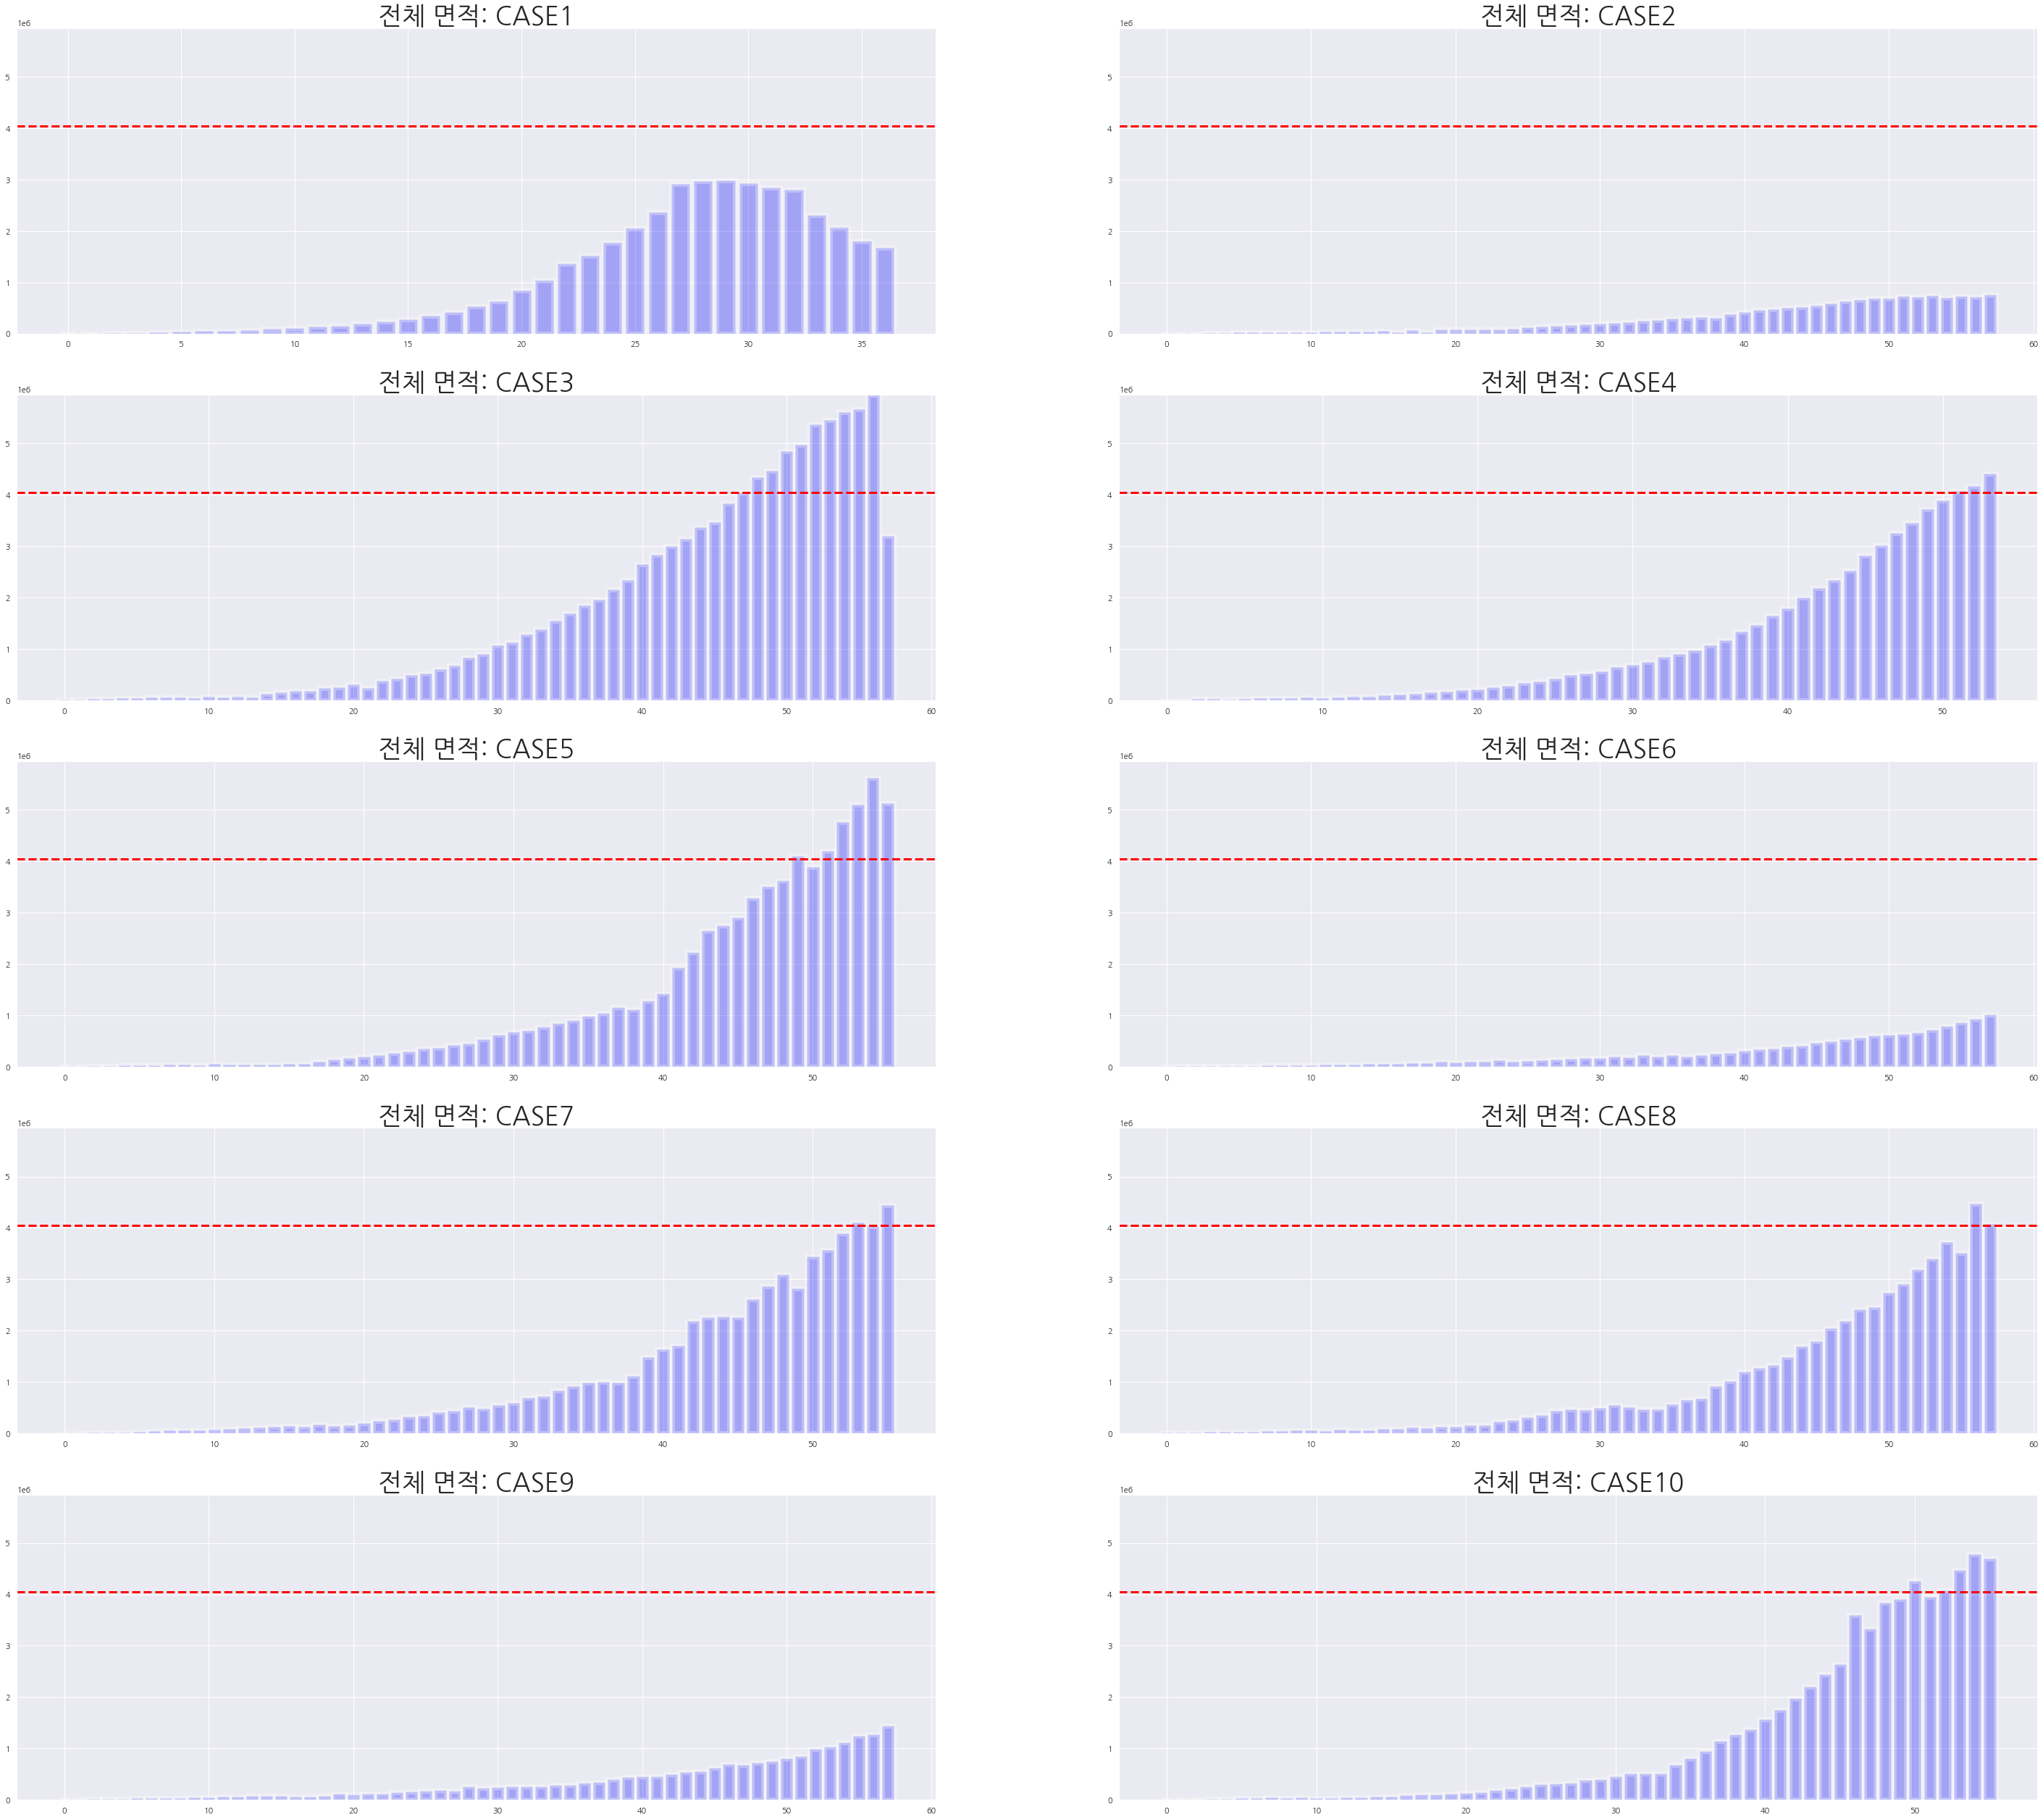

In [ ]:
# Quantile 95%

area_q95=df['전체면적'].quantile(0.95)

f, axes = plt.subplots(5, 2)
f.set_size_inches((50,45))


for i in range(len(dfs_area)):
    dfv=dfs_area[i]
    x=np.arange(len(dfv['전체면적']))
    plt.subplot(5,2,i+1)
    plt.bar(x,dfv['전체면적'], color='blue',linewidth=7.0,alpha=0.3)
    plt.title("전체 면적: CASE"+str(i+1),fontsize=35)
    plt.axhline(area_q95, 0, len(dfs_area[i]['전체면적']), color='red', linestyle='--', linewidth=3)
    plt.ylim([0,max(df['전체면적'])]) 

In [ ]:
# 기준 이상의 면적 데이터프레임 추출
df_area_q95=df[df['전체면적']>area_q95]

#이미지 경로 지정
q95_img_list=[]
for i in df_area_q95['case_idx'].unique():
    df_area_q95_split=df_area_q95[df_area_q95['case_idx']==i]
    
    default_path = "/content/drive/MyDrive/red_lettuce/CASE"+str(i)+"/" # 경로

    folder_list = os.listdir(default_path)
    #print(folder_list)
    
    folder=[]
    folder = [file for file in folder_list if file.startswith('image')]
    # print(folder)

    image_path=default_path+folder[0]+"/"

    image_list = sorted(os.listdir(image_path))
   # print(image_list)
             
    idx_max=df_area_q95_split['img_idx'].max()
    idx_min=df_area_q95_split['img_idx'].min()
    image_list=image_list[int(idx_min):int(idx_max)+1]
    
    
    for list_idx in range(len(image_list)):
        image_list[list_idx]=image_path+image_list[list_idx]
    
    q95_img_list.extend(image_list)
    
#q95_img_list

In [ ]:
#이미지 추출
f, axes = plt.subplots(math.ceil(len(q95_img_list)/3), 3)
f.set_size_inches(70,80)

for path in q95_img_list:
        
    plt.subplot(math.ceil(len(q95_img_list)/3), 3,q95_img_list.index(path)+1)
    
    img = cv.imread(path)
    img=cv.cvtColor(img,cv.COLOR_BGR2RGB)
    plt.imshow(img)
plt.show()


In [ ]:
print(f"[전체넓이] 판단 기준: {area_q95}")

[전체넓이] 판단 기준: 4044862.5


max except outlier를 기준으로 사용할 때 보다 Quantile 95%를 기준으로 사용할 때 비교적 잘 자란 적상추의 이미지를 가져오는 것을 확인할 수 있습니다.

**따라서  Quantile 95% 수치인 `4044862.5` 이상의 면적수치를 가진 이미지는 생육수준이 높은 적상추 이미지 임을 알 수 있다.**

## 3. 결론

### 3.1 분석 성과

- 적상추 이미지에서 **적상추 [전체면적], [청색면적], [적색면적] 지표 추출**
- 적상추 이미지에서 적상추의 [**전체면적] 중 [청색비율] 추출**
- 생육수준이 높은 적상추 이미지 추출이 가능한 [**전체면적] 지표의 기준 수립**

### 3.2 활용 방안

- [전체면적] 지표에 영향을 주는 환경조건 분석
- [청색면적]과 [적색면적] 지표에 영향을 주는 각각의 환경조건 분석